In [1]:
try:
    if installed:
        print('Installed')
except:
    !pip install -q gym[atari,accept-rom-license] ale-py
    installed = True

In [2]:
import cv2
import copy
import random
import gc
import gym
import sys
import numpy as np
import torch
import ipywidgets as widgets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from gym import spaces
from tqdm import tqdm
from collections import deque
from IPython import display
from IPython.display import clear_output
from matplotlib import animation

# sys.path.append('/kaggle/input/simplified-transformer-dir/')
from simplified_transformer_model import myGPT2Block

cv2.ocl.setUseOpenCL(False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import sys
import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
# sys.path.append('/kaggle/input/focal-unet/')
import focal_unet
from focal_unet import FocalNetBlock, FocalModulation, PatchEmbed, Final_PatchExpand

c:\Users\ROG\Desktop\Simplified_Transformer\focal_unet.py:771: UserWarning: Overwriting focalnet_tiny_srf in registry with focal_unet.focalnet_tiny_srf. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def focalnet_tiny_srf(pretrained=False, **kwargs):
c:\Users\ROG\Desktop\Simplified_Transformer\focal_unet.py:780: UserWarning: Overwriting focalnet_small_srf in registry with focal_unet.focalnet_small_srf. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def focalnet_small_srf(pretrained=False, **kwargs):
c:\Users\ROG\Desktop\Simplified_Transformer\focal_unet.py:789: UserWarning: Overwriting focalnet_base_srf in registry with focal_unet.focalnet_base_srf. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def focalnet_base_srf(pretrained=False, **kwargs):
c:\Users\ROG\Desktop\Simplified_Transfor

In [4]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.1, beta_start=0.1, beta_frames=50000):
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1

    def update_beta(self):
        self.frame += 1
        self.beta = min(1.0, self.beta_start + self.frame * (1.0 - self.beta_start) / self.beta_frames)

    def store(self, state, action, reward, next_state, done):
        max_priority = max(self.priorities) if self.buffer else 1.0
        self.buffer.append([state, action, reward, next_state, done])
        self.priorities.append(max_priority)

    def sample(self, batch_size):
        self.update_beta()
        total_priority = sum(self.priorities)
        probs = [priority / total_priority for priority in self.priorities]
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)

        states, actions, rewards, next_states, dones = zip(*[self.buffer[idx] for idx in indices])
        weights = [(len(self.buffer) * probs[idx]) ** (-self.beta) for idx in indices]
        weights = np.array(weights) / max(weights)

        states = np.array(states)
        next_states = np.array(next_states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)
        weights = np.array(weights)

        return states, actions, rewards, next_states, dones, indices, weights

    def update_priorities(self, indices, td_errors):
        for idx, td_error in zip(indices, td_errors):
            priority = (abs(td_error) + 1e-6) ** self.alpha
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.buffer)

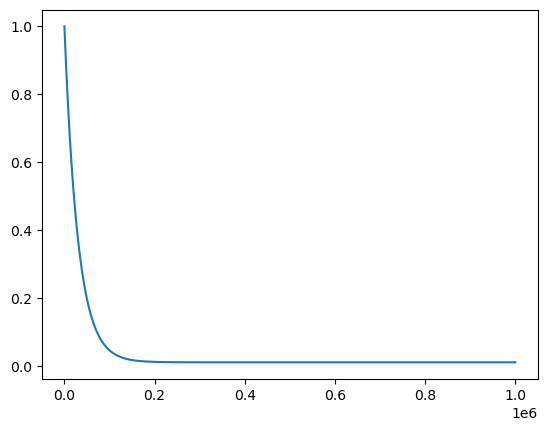

In [5]:
epsilon_S = 1.0
epsilon_E = 0.01
epsilon_decay = 30000

_epsilon = lambda frame: epsilon_E + (epsilon_S - epsilon_E)*np.exp(-frame/epsilon_decay)
plt.plot([_epsilon(frame) for frame in range(1000000)])

In [6]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.integers(1, self.noop_max + 1)
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _, info = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs, info

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _, info = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _, info = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs, info

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.was_real_done = done
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            done = True
        self.lives = lives
        return obs, reward, done, truncated, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs, info = self.env.reset(**kwargs)
        else:
            obs, _, _, _, info = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs, info

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=np.uint8)

    def reset(self):
        ob, info = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob(), info

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

def make_atari(env_id, render_mode=None):
    env = gym.make(env_id, render_mode = render_mode)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env



class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)
    

def wrap_pytorch(env):
    return ImageToPyTorch(env)

In [7]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id, render_mode='rgb_array')
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [8]:
def compute_td_loss(batch_size, device):
    states, actions, rewards, next_states, dones, indices, weights = replay_buffer.sample(batch_size)
    
    states      = torch.tensor(states).to(device)
    next_states = torch.tensor(next_states, requires_grad=False).to(device)
    actions     = torch.LongTensor(actions).to(device)
    rewards     = torch.FloatTensor(rewards).to(device)
    dones       = torch.FloatTensor(dones).to(device)
    weights     = torch.FloatTensor(weights).to(device)

    q_values      = model(states)
    next_q_values = model(next_states)

    q_value          = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = rewards + gamma * next_q_value * (1 - dones)

    td_errors = (q_value.detach() - expected_q_value.detach())
    replay_buffer.update_priorities(indices, td_errors.cpu().numpy())

    loss = (weights * (q_value - expected_q_value.detach()).pow(2)).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [9]:
class SASPConfig:
    def __init__(self, hidden_size, num_attention_heads, n_inner, n_layer, max_position_embeddings):
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.n_inner = n_inner
        self.n_layer = n_layer
        self.max_position_embeddings = max_position_embeddings
        
        self.parallel_layers = True
        self.norm_type = "ln"
        self.norm_position = "pre"
        
        self.attn_block_resid_gain = 1.0
        self.attn_block_skip_gain = 0.0
        self.mlp_block_resid_gain = 1.0
        self.mlp_block_skip_gain = 0.0
        
        self.value_resid_gain = 0.0
        self.proj_resid_gain = 0.0
        self.first_layer_value_resid_gain = None
        
        self.value_skip_gain = 1.0
        self.proj_skip_gain = 1.0
        self.val_init_type = "id"
        self.proj_init_type = "id"
        
        self.centre_attn = True
        self.attn_mat_resid_gain = 1.0
        self.attn_mat_skip_gain = 1.0
        self.centre_attn_gain = 1.0
        
        self.query_init_std = 0.0
        self.key_init_std = None
        self.val_proj_init_std = None
        self.mlp_proj_init_std = None
        self.last_layer_proj_resid_gain = None
        
        self.activation_function = "gelu"
        self.resid_pdrop = 0.0
        self.attn_pdrop = 0.0
        self.layer_norm_epsilon = 1e-5
        
        self.scale_attn_weights = True
        self.scale_attn_by_inverse_layer_idx = False
        
        self.trainable_attn_block_gains = False
        self.trainable_mlp_block_gains = False
        self.trainable_value_gains = False
        self.trainable_proj_gains = False
        self.trainable_attn_mat_gains = True

In [10]:
def img_by_obs(obs, state_dim):
    """
    Unwraps obs by channels.
    observation is of shape [c, h=w, w=h]
    """
    return obs.reshape([-1, state_dim[2]])


In [11]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

        self.focal_block = FocalNetBlock(
            dim=64, input_resolution=(input_shape[1]//8, input_shape[2]//8),
            mlp_ratio=4.0, drop=0.1, focal_level=1, focal_window=3)
        self.focal_block.B = 1
        
        self.patch_embed = PatchEmbed(
            img_size=to_2tuple(input_shape[1] // 8), 
            patch_size=1, 
            in_chans=64, 
            embed_dim=64, 
            use_conv_embed=False, 
            norm_layer=nn.LayerNorm, 
            is_stem=True)

        self.patch_expand = Final_PatchExpand(
            img_size=(7, 7),
            patch_size=1,
            in_chans=64,
            embed_dim=64,
            use_conv_embed=False,
            norm_layer=nn.LayerNorm,
            is_stem=True)
        
        sasp_config = SASPConfig(
            hidden_size=self.feature_size(),
            num_attention_heads=1,
            n_inner=256,
            n_layer=1,
            max_position_embeddings=1
        )
        
        self.transformer = myGPT2Block(sasp_config)

        
    def forward(self, x):
        x = x.float()
        x = self.features(x)
        
        x = self.patch_embed(x)
        x, H, W = x
        self.focal_block.H, self.focal_block.W = H, W
        x = self.focal_block(x)
        x = self.patch_expand(x)
        x, H, W = x
        
        x = x.reshape(x.size(0), -1)
        x = x.unsqueeze(1)
        x = self.transformer(x)[0]
        x = x.squeeze(1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(torch.autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        with torch.no_grad():
            if random.random() > epsilon:
                state   = torch.FloatTensor(state).unsqueeze(0)
                state = state.to(device)
                q_value = self.forward(state)
                action  = q_value.max(1)[1].item()
            else:
                action = random.randrange(env.action_space.n)
        return action

In [12]:
model = CnnDQN(env.observation_space.shape, env.action_space.n)

model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_initial = 10000
replay_buffer = PrioritizedReplayBuffer(50000)

In [13]:
def plot(frame_idx, rewards, losses, game, game_data):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.subplot(133)
    plt.title(f'ep: {game_data[1]} max step: {game_data[2]}')
    plt.imshow(game)
    plt.show()

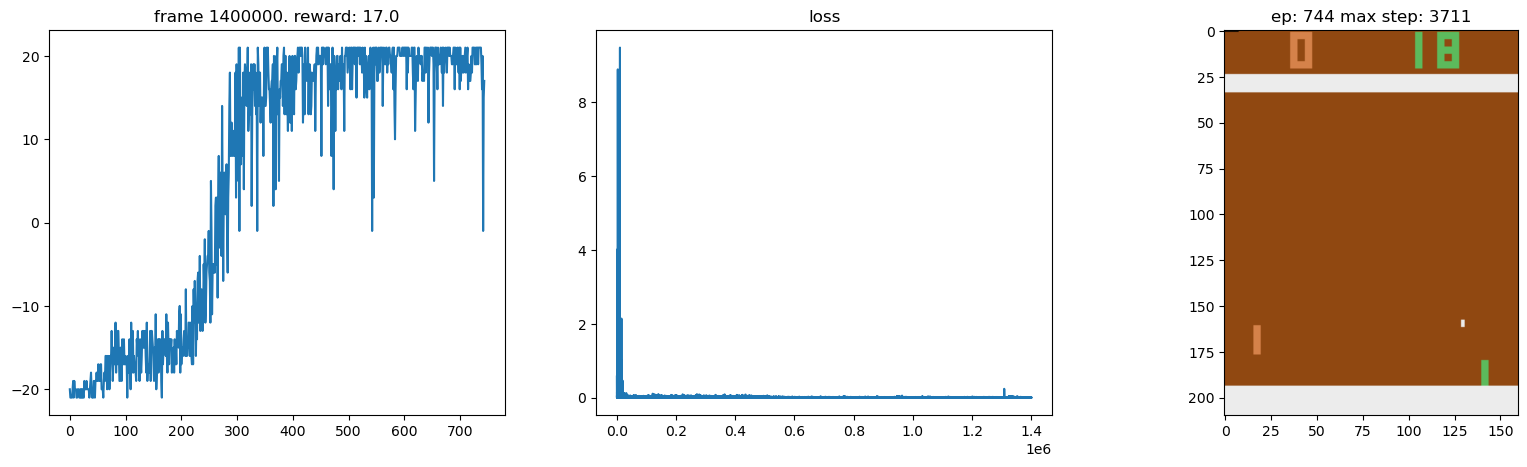

100%|██████████| 1400000/1400000 [13:18:46<00:00, 29.21it/s]


In [14]:
num_frames = 1400000
batch_size = 32
gamma      = 0.99
position_shape = 6

losses = []
all_rewards = []
episode_reward = 0
step = 0
ep = 0
max_steps = 0

state, _ = env.reset()
for frame_idx in tqdm(range(1, num_frames + 1)):
    
    epsilon = _epsilon(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _, _ = env.step(action)
    replay_buffer.store(state, action, reward, next_state, float(done))
    
    state = next_state
    episode_reward += reward
    step += 1
    
    if done:
        state, _ = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        max_steps = max(step, max_steps)
        step = 0
        ep += 1
        gc.collect()
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size, device)
        losses.append(loss)
      
    if frame_idx % 10000 == 0:
        rgb_array = env.render()
        plot(frame_idx, all_rewards, losses, rgb_array, (step, ep, max_steps))

In [15]:
for i, r in enumerate(all_rewards):
    if r >= 20:
        print("First episode above 20: " + str(i))
        break
print("Max reward", str(max(all_rewards)))

First episode above 20: 303
Max reward 21.0


In [16]:
for i, r in enumerate(all_rewards):
    if r > 0:
        print("First episode above 0: " + str(i))
        break
        
max_mean10, max_mean40 = -21, -21
mean10_e, mean40_e = -1, -1
for i in range(10, len(all_rewards)):
    last_10_reward = np.mean(all_rewards[i-10:i])
    if last_10_reward > max_mean10:
        mean10_e = i
        max_mean10 = last_10_reward
    if i >= 40:
        last_40_reward = np.mean(all_rewards[i-40:i])
        if last_40_reward > max_mean40:
            mean40_e = i
            max_mean40 = last_40_reward
        
    
print("Max mean-10 reward: " + "episode " + str(mean10_e) + ": " + str(max_mean10))
print("Max mean-40 reward: " + "episode " + str(mean40_e) + ": " + str(max_mean40))

First episode above 0: 253
Max mean-10 reward: episode 598: 20.6
Max mean-40 reward: episode 695: 19.7


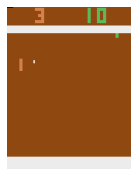

In [26]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=10)

    anim.save(path + filename, writer='imagemagick', fps=6)
    
    
state, _ = env.reset()
action = 0
frames = []
final_reward = 0
for t in tqdm(range(1000)):
    frames.append(env.render())
    action = model.act(state, epsilon)
    state, reward, done, _, _ = env.step(action)
    final_reward += reward
    if done:
        break

save_frames_as_gif(frames)
clear_output(wait=True)

In [27]:
print(final_reward)

7.0


In [18]:
gif_file = './gym_animation.gif'
file = open(gif_file, "rb")
image = file.read()
widgets.Image(
    value=image,
    format='png',
    width=300,
    height=400,
)

Image(value=b'GIF89a\xa0\x00\xd2\x00\x84\x00\x00\x90H\x11\xff\xff\xff\xec\xec\xec\\\xb9[\xa5g:\xbc\x97{\xae~Z\…

In [19]:
torch.save(model, 'pingpong_dqn.pth')